In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import os

In [2]:
# Set the path to your dataset directory
dataset_dir = "D:/CAPSTONE PROJECT/KIDNEY DATASET"

In [4]:
# Define image dimensions and batch size
img_height = 256
img_width = 256
batch_size = 32

In [5]:
# Create data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 2921 images belonging to 3 classes.
Found 1017 images belonging to 3 classes.


In [6]:
# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [8]:
# Build the VGG-19 model
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=3
)

In [9]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Assuming 3 classes: normal, stone, tumor

In [10]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/15
91/91 [==============================] - 689s 8s/step - loss: 0.9079 - accuracy: 0.5850 - val_loss: 0.7062 - val_accuracy: 0.7702
Epoch 2/15
91/91 [==============================] - 1588s 18s/step - loss: 0.6340 - accuracy: 0.7560 - val_loss: 0.5159 - val_accuracy: 0.7802
Epoch 3/15
91/91 [==============================] - 1756s 19s/step - loss: 0.5636 - accuracy: 0.7577 - val_loss: 0.3967 - val_accuracy: 0.8196
Epoch 4/15
91/91 [==============================] - 1872s 21s/step - loss: 0.4684 - accuracy: 0.8055 - val_loss: 0.3251 - val_accuracy: 0.8518
Epoch 5/15
91/91 [==============================] - 1746s 19s/step - loss: 0.3862 - accuracy: 0.8546 - val_loss: 0.3914 - val_accuracy: 0.8216
Epoch 6/15
91/91 [==============================] - 1760s 19s/step - loss: 0.3536 - accuracy: 0.8626 - val_loss: 0.2648 - val_accuracy: 0.8639
Epoch 7/15
91/91 [==============================] - 1050s 11s/step - loss: 0.3308 - accuracy: 0.8775 - val_loss: 0.2530 - val_accuracy: 0.8700
E

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix


In [14]:
# Plotting graphs for accuracies and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

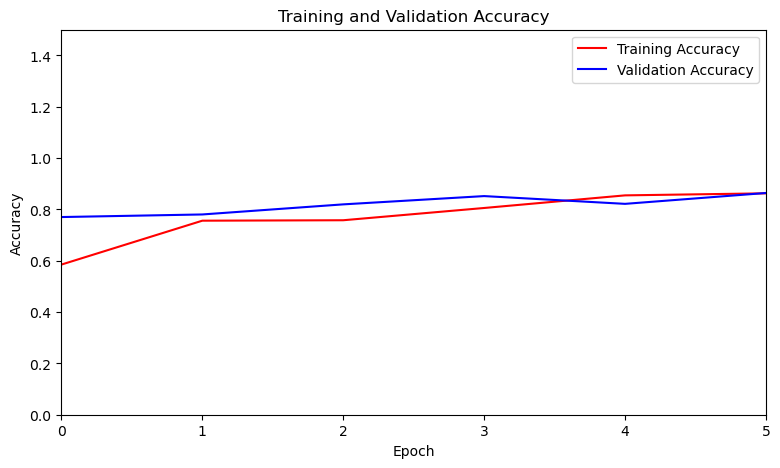

In [15]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0, 5) 
plt.ylim(0.0, 1.5)
plt.legend()
plt.show()

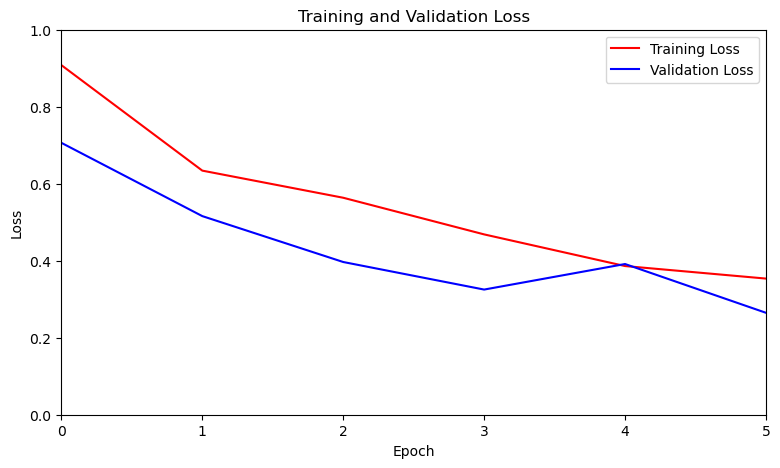

In [16]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 5) 
plt.ylim(0, 1.0)
plt.legend()

plt.show()

1/1 [==============================] - 0s 388ms/step


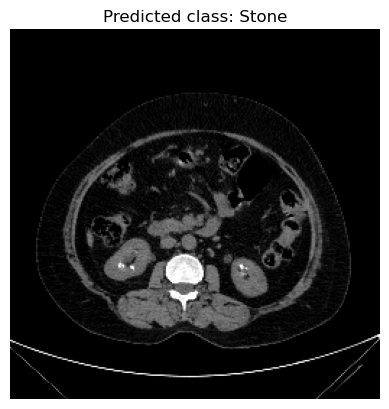

In [17]:
# Predicting on a test image
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    predictions = model.predict(img_array)
    classes = ['Normal', 'Stone', 'Tumor']
    predicted_class = classes[np.argmax(predictions)]
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Predicted class: " + predicted_class)
    plt.show()

# Provide the path to the test image
test_image_path = "D:/CAPSTONE PROJECT/KIDNEY DATASET/Train/Stone/Stone- (439).jpg"
predict_image(test_image_path)

1/1 [==============================] - 0s 260ms/step


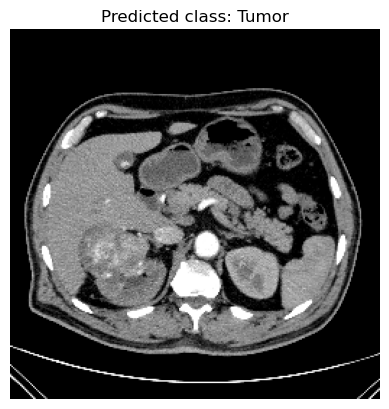

In [18]:
# Predicting on a test image
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    predictions = model.predict(img_array)
    classes = ['Normal', 'Stone', 'Tumor']
    predicted_class = classes[np.argmax(predictions)]
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Predicted class: " + predicted_class)
    plt.show()

# Provide the path to the test image
test_image_path = "D:/CAPSTONE PROJECT/KIDNEY DATASET/Test/Tumour/Tumor- (446).jpg"
predict_image(test_image_path)

1/1 [==============================] - 0s 266ms/step


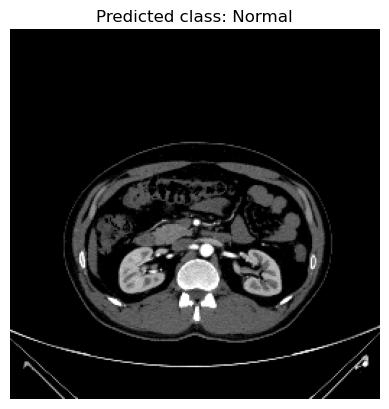

In [19]:
# Predicting on a test image
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    predictions = model.predict(img_array)
    classes = ['Normal', 'Stone', 'Tumor']
    predicted_class = classes[np.argmax(predictions)]
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Predicted class: " + predicted_class)
    plt.show()

# Provide the path to the test image
test_image_path = "D:/CAPSTONE PROJECT/KIDNEY DATASET/Test/Normal/Normal- (1797).jpg"
predict_image(test_image_path)

In [24]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save("D:/CAPSTONE PROJECT/KIDNEY DATASET/kidneydiagnosis_vgg19.h5")

In [25]:
# Importing all important libraries
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns           # for working with maps
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [26]:
train_data="D:/CAPSTONE PROJECT/KIDNEY DATASET/Train"
# Validation Data
valid_data="D:/CAPSTONE PROJECT/KIDNEY DATASET/Test"

In [27]:
# Create a rescaling layer in a Keras model
rescale=keras.layers.Rescaling(scale=1.0/255)

In [33]:
# Create TensorFlow tf.data.Dataset objects from image directories for training and validation data in Keras
# Images are loaded with the specified image size of (256, 256), and the function image_dataset_from_directory assigns labels based on subdirectory names
training_data =keras.utils.image_dataset_from_directory(train_data , image_size=(256, 256))
validation_data = keras.utils.image_dataset_from_directory(valid_data, image_size=(256, 256))

Found 2921 files belonging to 3 classes.
Found 1017 files belonging to 3 classes.


In [34]:
validation_data = keras.utils.image_dataset_from_directory(valid_data, image_size=(256, 256))

Found 1017 files belonging to 3 classes.


In [35]:
valid_gen  = validation_data.map(lambda image,label:(rescale(image),label))

In [36]:
from tensorflow.keras.models import load_model
model=load_model("D:/CAPSTONE PROJECT/KIDNEY DATASET/kidneydiagnosis_vgg19.h5")

In [37]:
# Obtain the labels and predictions for the validation data.
labels = []
predictions = []
for x,y in valid_gen:
    labels.append(list(y.numpy()))
    predictions.append(ts.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 12s 12s/step


In [38]:
# Flatten the nested lists of predictions and labels
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [39]:
# Print various evaluation metrics based on the model's performance
print("Train Accuracy  : {:.2f} %".format(0.9318*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))

Train Accuracy  : 93.18 %
Test Accuracy   : 91.45 %


<Figure size 500x500 with 0 Axes>

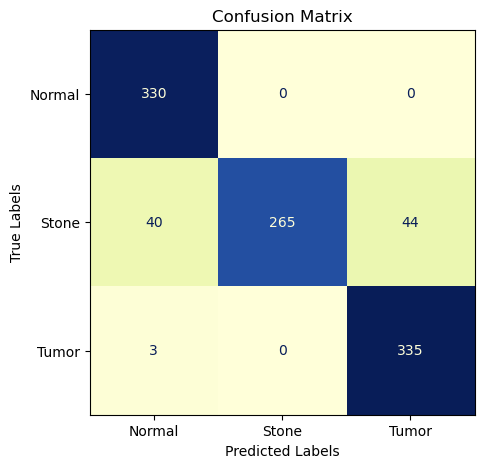

In [40]:
# Plot a confusion matrix based on the true labels and predicted labels
plt.figure(figsize=(5, 5))  # Remove this line
cm = confusion_matrix(labels, predictions)
class_labels = ['Normal', 'Stone', 'Tumor']  # Define class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(5, 5))  # Corrected line
disp.plot(ax=ax, colorbar=False, cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [41]:
from sklearn.metrics import f1_score, recall_score, precision_score

# Calculate F1 score
f1 = f1_score(labels, predictions, average='weighted') * 100

# Calculate recall score
recall = recall_score(labels, predictions, average='weighted') * 100

# Calculate precision score
precision = precision_score(labels, predictions, average='weighted') * 100

print("F1 Score: {:.3f} %".format(f1))
print("Recall Score: {:.3f} %".format(recall))
print("Precision Score: {:.3f} %".format(precision))


F1 Score: 91.142 %
Recall Score: 91.445 %
Precision Score: 92.401 %
